# MEng-Team-Project-ML

This notebook contains the initial analysis of SQLite DB files generated \
by our ML system as of December 2022 (refer to git commit for exact \
version).

Each one of our key objectives is potentially non-trivial to implement. \
The issues with each objective are listed below: 
- Object Identification 
  - This objective is the easiest to implement as we have the predicted \
    object along with it's bounding box per frame. However, across different \
    frames the object and camera can experience different scenarios which \
    can make relying on any individual frame invalid. For example, the \
    `00001.01350_2022-12-07T15-35-24.000Z.mp4` test file in the daytime \
    dataset on Google Drive shows the bus which is driving away from the \
    camera as being misidentified as a truck closer towards the middle / \
    end of the video. This is a common theme throughout the TFL JamCam \
    datasets. One way to rectify this, is to take the object predictions across \
    the entire time the object is in view (by taking it's predicted anchor value) \
    and determining the mode of the predicted classes. This is likely to be correct \
    for nice scenarios (day time, no glare). This needs to be deliberated further \
    for harder conditions such as night time / snow, etc.
- Object Count
  - For this objective, although it may appear simple on the surface, is \
    actually non-trivial because we have to correctly count the number of \
    objects across a time period. This becomes difficult for two reasons, \
    firstly we have to correctly identify the same object moving across \
    the field of view which can be problematic if the object is momentarily \
    obscured for whatever reason (e.g. camera blur, goes out of view and then \
    back into view. For example in our case, an object could cross from one exit \
    onto another exit in the Bunarby Road junction but be blocked by a HGV vehicle. \
    This would now count as a new object which would affect our counting of the objects). \
    The second issue is if the object is momentarily miscategorised which means that \
    yolov7's default method of tracking the object considers it a different object.
- Object Tracking
  - Similar to the above issue, object tracking relies on being able to identify the object \
    you are tracking as the same object across different frames. If an object is misidentified \
    partially before the video ends or the object exits the frame, this can cause the object \
    tracker to treat the object which was already being tracked as a new object. In theory, \
    we could implement code to see where a route / object was already being tracked and treat \
    it as the same object if it is reasonably close to what was being tracked before. This requires \
    testing / experimenting / tweaking. It is likely we can get a solution which is good enough \
    but I don't think we can straight up solve this issue as it has complex, non-trivial edge cases.

## Load Dataset

### Load COCO Classes

In [1]:
import yaml

COCO_YAML_PATH = "../yolov7-segmentation/data/coco.yaml"

def load_coco_classes(coco_settings):
    with open(coco_settings, "r") as stream:
        try:
            coco_data = yaml.safe_load(stream)
            coco_data = coco_data["names"]
            return coco_data
        except yaml.YAMLError as exc:
            print(exc)

COCO_CLASSES = load_coco_classes(COCO_YAML_PATH)

### Load Pre-Saved Analytical Dataset (SQLite)

In [2]:
import os
from traffic_ml.lib.gdrive import get_gdrive_id, download_file_from_google_drive

TEST_FILE_FNAME = "00001.01350_2022-12-07T15-35-24.000Z.db"
TEST_FILE_LINK  = "https://drive.google.com/file/d/1egktGrOytFn58TV38Ss3U4NHOIaSyE54/view?usp=sharing"

gdrive_id = get_gdrive_id(TEST_FILE_LINK)
out = download_file_from_google_drive(gdrive_id, f"./{TEST_FILE_FNAME}")

if os.path.exists(TEST_FILE_FNAME):
    print("Downloaded successfully!")
else:
    print(f"Error downloading: {TEST_FILE_FNAME}")

Downloaded successfully!


## Data Analysis

### Load Data into Dataframes

In [3]:
import sqlite3
import pandas as pd

con = sqlite3.connect(TEST_FILE_FNAME)

# Detected Objects per Frame
detections_df = pd.read_sql_query("SELECT * FROM detections;", con)
detections_df["class_idx"]   = detections_df["class_idx"].astype(int)
detections_df["class_label"] = detections_df["class_idx"].apply(lambda item: COCO_CLASSES[item])

# Tracked Objects per Frame (Kalman Filter)
tracked_df    = pd.read_sql_query("SELECT * FROM tracked;", con)

# Object Routes through Video Feed (Across Frames, Kalman Filter)
routes_df     = pd.read_sql_query("SELECT * FROM route;", con)

con.close()

### Recorded Info Count (per Frame)

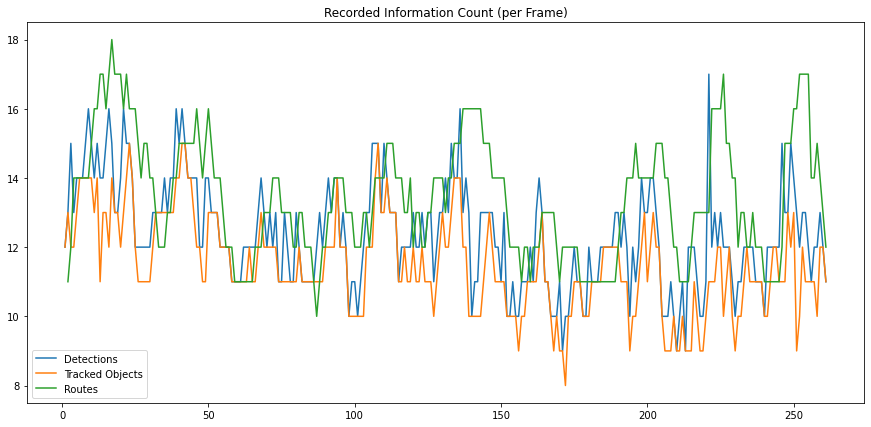

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

det_count    = detections_df["frame"].value_counts().sort_index()
track_count  = tracked_df["frame"].value_counts().sort_index()
routes_count = routes_df.groupby("frame")["route_idx"].max().sort_index()

plt.title("Recorded Information Count (per Frame)")
plt.plot(det_count, label="Detections")
plt.plot(track_count, label="Tracked Objects")
plt.plot(routes_count, label="Routes")
plt.legend()

### Identify Objects in Each Scene

#### Frame and Class Label

In [5]:
detections_df[["frame", "class_label"]]

,frame,class_label
0,1,person
1,1,car
2,1,car
3,1,person
4,1,truck
...,...,...
3223,261,car
3224,261,person
3225,261,person
3226,261,car


#### Filter Classes to Requirements

In [6]:
target_classes = ["bicycle", "car", "bus", "truck", "person"]
target_idxs    = [COCO_CLASSES.index(target_class)
                  for target_class in target_classes]

detections_df = detections_df[detections_df["class_label"].isin(target_classes)]
detections_df

,detection_id,frame,class_idx,x1,y1,x2,y2,confidence,class_label
0,0,1,0,1.0,176.0,10.0,204.0,0.361816,person
1,1,1,2,152.0,71.0,166.0,89.0,0.465332,car
2,2,1,2,187.0,110.0,226.0,127.0,0.483398,car
3,3,1,0,68.0,113.0,75.0,131.0,0.526855,person
4,4,1,7,187.0,110.0,225.0,127.0,0.541016,truck
...,...,...,...,...,...,...,...,...,...
3223,3223,261,2,131.0,92.0,150.0,104.0,0.656250,car
3224,3224,261,0,20.0,137.0,27.0,159.0,0.659668,person
3225,3225,261,0,26.0,137.0,35.0,163.0,0.697266,person
3226,3226,261,2,177.0,99.0,189.0,109.0,0.710449,car


### Track Objects in Each Scene

In [7]:
# Original Video Dims for Context (352x288)
tracked_df["label"].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 13, 15, 14, 18, 19,
       20, 21, 22, 24, 26, 27, 29, 28, 31, 32, 35, 38, 40, 39, 41, 42, 43,
       44, 45, 48, 47, 50, 52, 55, 57, 59, 60, 62, 64, 63, 65, 66, 68, 70,
       69, 75, 74, 73, 79, 83, 81, 80, 86, 85, 87], dtype=int64)

In [8]:
# tracked_df.iloc[0:20]
tracked_df

,tracked_id,frame,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label,anchor_x,anchor_y
0,0,1,1.0,176.0,10.0,204.0,12,5.0,190.0
1,1,1,152.0,71.0,166.0,89.0,11,159.0,80.0
2,2,1,187.0,110.0,226.0,127.0,10,206.0,118.0
3,3,1,68.0,113.0,75.0,131.0,9,71.0,122.0
4,4,1,187.0,110.0,225.0,127.0,8,206.0,118.0
...,...,...,...,...,...,...,...,...,...
2992,2992,261,2.0,166.0,13.0,190.0,48,8.0,178.0
2993,2993,261,132.0,77.0,144.0,89.0,40,138.0,83.0
2994,2994,261,176.0,99.0,189.0,108.0,35,183.0,103.0
2995,2995,261,131.0,91.0,150.0,104.0,24,140.0,97.0


In [9]:
import numpy as np
detections_df["x"] = np.floor((detections_df["x2"] + detections_df["x1"]) / 2)
detections_df["y"] = np.floor((detections_df["y2"] + detections_df["y1"]) / 2)

In [10]:
detections_df

,detection_id,frame,class_idx,x1,y1,x2,y2,confidence,class_label,x,y
0,0,1,0,1.0,176.0,10.0,204.0,0.361816,person,5.0,190.0
1,1,1,2,152.0,71.0,166.0,89.0,0.465332,car,159.0,80.0
2,2,1,2,187.0,110.0,226.0,127.0,0.483398,car,206.0,118.0
3,3,1,0,68.0,113.0,75.0,131.0,0.526855,person,71.0,122.0
4,4,1,7,187.0,110.0,225.0,127.0,0.541016,truck,206.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...
3223,3223,261,2,131.0,92.0,150.0,104.0,0.656250,car,140.0,98.0
3224,3224,261,0,20.0,137.0,27.0,159.0,0.659668,person,23.0,148.0
3225,3225,261,0,26.0,137.0,35.0,163.0,0.697266,person,30.0,150.0
3226,3226,261,2,177.0,99.0,189.0,109.0,0.710449,car,183.0,104.0


In [11]:
# NOTE: Below is not working

import numpy as np

tracked_df = tracked_df.rename(columns={"anchor_x": "x", "anchor_y": "y"})

# NOTE: Match the first tracked object
# match (frame, x, y)

def get_matching_detection(tracked_row):
    try:
        detections_df_cur_frame = detections_df[detections_df["frame"] == tracked_row["frame"]]
        matching_idx = (tracked_row["x"] == detections_df_cur_frame["x"]) & \
                        (tracked_row["y"] == detections_df_cur_frame["y"])
        if any(matching_idx):
            matching_idx = matching_idx[matching_idx == True]
            if len(matching_idx) > 1:
                pass # print("HOW?:", matching_idx)
            if len(matching_idx) > 0:
                matched_coord_idx = matching_idx.index[0]
            else:
                return -1
            detection_row = detections_df.iloc[matched_coord_idx]
            return detection_row.name
        else:
            return -1
    except Exception as e:
        # print("ELLO:", e, matching_idx, "<", matched_coord_idx, ">GEEZA")
        return -1

# test_tracked_df = tracked_df[(tracked_df["frame"] == 1) | (tracked_df["frame"] == 2)]
tracked_df_matching_det = tracked_df.apply(lambda row: get_matching_detection(row), axis=1)
tracked_df_matching_det

0       0
1       1
2       2
3       3
4       2
       ..
2992   -1
2993   -1
2994   -1
2995   -1
2996   -1
Length: 2997, dtype: int64

In [12]:
tracked_df_matching_det.iloc[1]

1

## Yolov8 Kalman Verification

In [9]:
detections_df[detections_df["frame"] < 3]

,detection_id,frame,class_idx,x1,y1,x2,y2,confidence,class_label
0,0,1,0,1.0,176.0,10.0,204.0,0.361816,person
1,1,1,2,152.0,71.0,166.0,89.0,0.465332,car
2,2,1,2,187.0,110.0,226.0,127.0,0.483398,car
3,3,1,0,68.0,113.0,75.0,131.0,0.526855,person
4,4,1,7,187.0,110.0,225.0,127.0,0.541016,truck
5,5,1,0,76.0,115.0,83.0,132.0,0.541504,person
6,6,1,0,26.0,153.0,38.0,175.0,0.591797,person
7,7,1,2,175.0,98.0,190.0,111.0,0.612793,car
8,8,1,5,128.0,94.0,161.0,161.0,0.676758,bus
9,9,1,0,298.0,157.0,304.0,182.0,0.682129,person


In [12]:
for frame in [1, 2]:
    l = detections_df[detections_df["frame"] == frame].shape[0]
    print(l)

12
13


In [10]:
tracked_df[tracked_df["frame"] < 3]

,tracked_id,frame,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label,anchor_x,anchor_y
0,0,1,1.0,176.0,10.0,204.0,12,5.0,190.0
1,1,1,152.0,71.0,166.0,89.0,11,159.0,80.0
2,2,1,187.0,110.0,226.0,127.0,10,206.0,118.0
3,3,1,68.0,113.0,75.0,131.0,9,71.0,122.0
4,4,1,187.0,110.0,225.0,127.0,8,206.0,118.0
5,5,1,76.0,115.0,83.0,132.0,7,79.0,123.0
6,6,1,26.0,153.0,38.0,175.0,6,32.0,164.0
7,7,1,175.0,98.0,190.0,111.0,5,182.0,104.0
8,8,1,128.0,94.0,161.0,161.0,4,144.0,127.0
9,9,1,298.0,157.0,304.0,182.0,3,301.0,169.0


In [13]:
for frame in [1, 2]:
    l = tracked_df[tracked_df["frame"] == frame].shape[0]
    print(l)

12
13


In [11]:
routes_df[routes_df["frame"] < 3]

,sub_route_id,frame,route_idx,x1,y1,x2,y2
0,0,2,0,232.0,169.0,232.0,169.0
1,1,2,1,143.0,83.0,143.0,83.0
2,2,2,2,301.0,169.0,301.0,169.0
3,3,2,3,144.0,127.0,144.0,127.0
4,4,2,4,182.0,104.0,182.0,104.0
5,5,2,5,32.0,164.0,31.0,165.0
6,6,2,6,79.0,123.0,79.0,123.0
7,7,2,7,206.0,118.0,206.0,118.0
8,8,2,8,71.0,122.0,71.0,122.0
9,9,2,9,206.0,118.0,206.0,118.0


In [14]:
for frame in [1, 2]:
    l = routes_df[routes_df["frame"] == frame].shape[0]
    print(l)

0
12
